In [1]:
%matplotlib inline

from classes.DQNagentClass import DQNAgent, DDQNAgent
from envs.createEnvs import createNNEnv
from utilities.plots import create_grids, plot_trajectory
from utilities.jsonRW import writeJSON

In [ ]:
#CREATING THE ENVIRONMENT
shape = "5x5"             # "5x5" or "14x14"
env = createNNEnv(shape)

Loading models...
Models loaded


In [ ]:
#Hyperparameters
show_stats = True      # show stats
export_to_JSON = False  # write JSON file
render = True           # render the results after training

NUM_DQN_AGENTS = 11      # number of DQN agents
NUM_DDQN_AGENTS = 0     # number of DDQN agents

NUM_NEURONS_FC1 = 128   # number of neurons for the first fully connected layer
NUM_NEURONS_FC2 = 128   # number of neurons for the second fully connected layer

EPISODES_PER_AGENT = 800
MAX_STEPS_PER_EPISODE = 25

EPS_START = 1.0         # epsilon start value
EPS_END = 0.01          # epsilon end value
EPS_DECAY = 0.996       # epsilon decay rate
#EPS_DECAY = EPS_START/(EPISODES_PER_AGENT/2)

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [ ]:
#CREATING AND TRAINING THE AGENTS
agents_arr = []         # array of agents
starting_positions = [] # array of starting positions for each agent

for i in range(NUM_DQN_AGENTS+NUM_DDQN_AGENTS):
    if i < NUM_DQN_AGENTS:
        print("DQN Agent", i+1,"/",NUM_DQN_AGENTS)    # if the agent is a DQN agent
        path_to_save = "../data/agent_models/pytorch/DQNagent"+str(i+1)+".pt" # path to save the model
        agent = DQNAgent(path_to_save, env, NUM_NEURONS_FC1, NUM_NEURONS_FC2, EPISODES_PER_AGENT, MAX_STEPS_PER_EPISODE, EPS_START, EPS_END, EPS_DECAY, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY)
    else:
        print("DDQN Agent", i+1-NUM_DQN_AGENTS,"/",NUM_DDQN_AGENTS)  # if the agent is a DDQN agent 
        path_to_save = "../data/agent_models/pytorch/DDQNagent"+str(i+1)+".pt" # path to save the model
        agent = DDQNAgent(path_to_save, env, NUM_NEURONS_FC1, NUM_NEURONS_FC2, EPISODES_PER_AGENT, MAX_STEPS_PER_EPISODE, EPS_START, EPS_END, EPS_DECAY, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY)

    agent.env.unwrapped.randomize_start_pos()
    
    agent.train()

    agents_arr.append(agent)
    starting_positions.append(agent.env.unwrapped.start_pos)

DQN Agent 1 / 2


  0%|          | 0/800 [00:00<?, ?it/s]c:\Users\Blanca\anaconda3\envs\salva2\lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 800/800 [00:19<00:00, 40.32it/s]


DQN Agent 2 / 2


100%|██████████| 800/800 [00:14<00:00, 55.39it/s] 


Agent 1 steps stats: 	Average 12.66 	Std dev 5.26 	Median 10.0 	Best 8


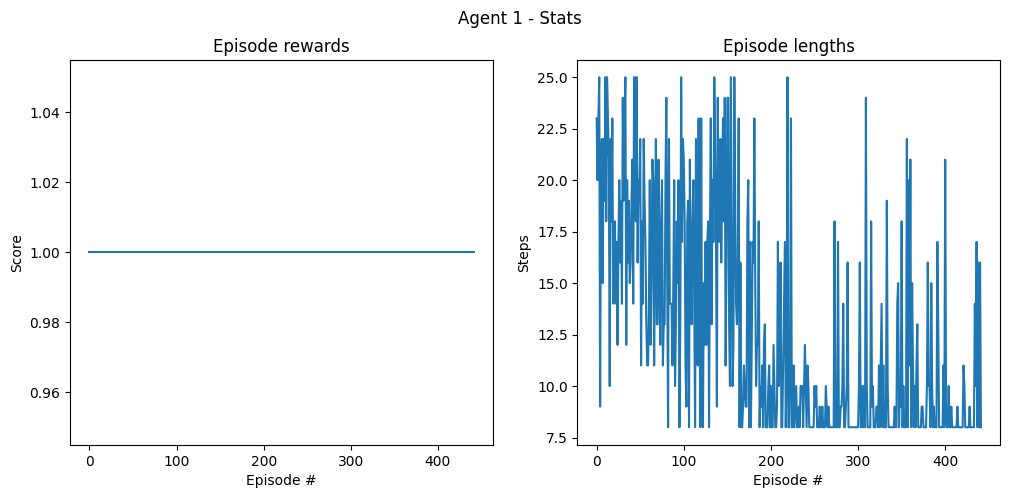

Agent 2 steps stats: 	Average 8.4 	Std dev 4.07 	Median 7.0 	Best 6


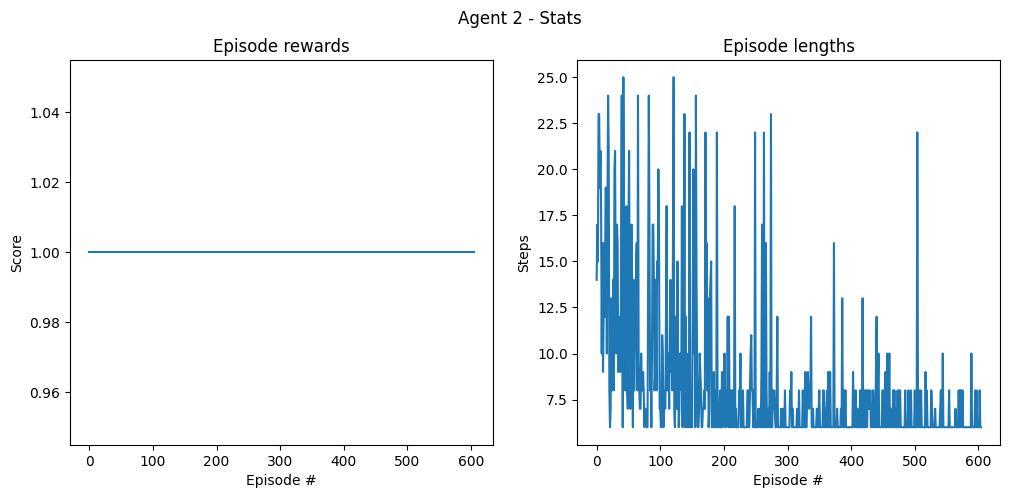

In [ ]:
if show_stats:
    for i in range(len(agents_arr)):
        agents_arr[i].plot_results(i, rolling_length=1)

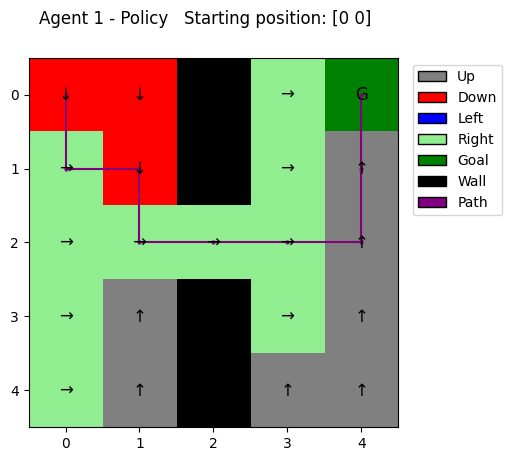

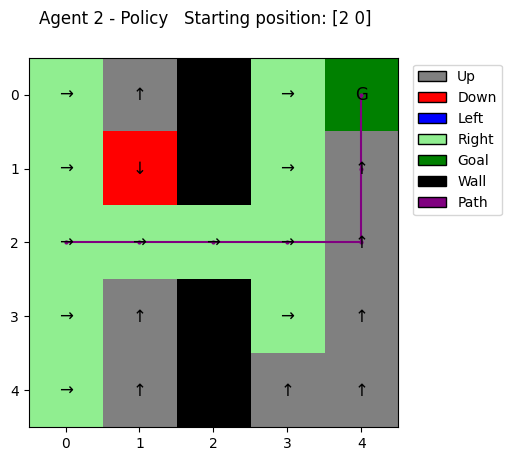

In [ ]:
for i in range(len(agents_arr)):
    value_grid, policy_grid, string_policy_grid = create_grids(env, Qnet=agents_arr[i].qnetwork_local)
    
    if export_to_JSON:
        if i < NUM_DQN_AGENTS:
            algorithm = "DQN"
        else:
            algorithm = "DDQN"

        writeJSON(algorithm, EPISODES_PER_AGENT, MAX_STEPS_PER_EPISODE, shape, starting_positions[i], value_grid, policy_grid, string_policy_grid)
    
    if render:
        plot_trajectory(string_policy_grid, starting_positions[i], i)


In [ ]:
#Para cargar todos los modelos que haya creados
"""
    for agent in agents_arr:
        #Aqui tenemos el problema de no conocer sus starting positions originales??
        #env = createNNEnv(shape, randomStart=True)
        if agents_arr.index(agent) < NUM_DQN_AGENTS:
            print("DQN Agent", agents_arr.index(agent)+1,"/",len(agents_arr))
            path_to_load = "../data/agent_models/pytorch/DQNagent"+str(agents_arr.index(agent)+1)+".pt"
        else:
            print("DDQN Agent", agents_arr.index(agent)+1,"/",len(agents_arr))
            path_to_load = "../data/agent_models/pytorch/DDQNagent"+str(agents_arr.index(agent)+1-NUM_DQN_AGENTS)+".pt"
        agent.qnetwork_local.load_state_dict(torch.load(path_to_load))
        agent.qnetwork_local.eval()"""

#Demostracion de un agente en el entorno
#Hay que tener cuidado de darle correctamente el mismo tamaño de capas que al modelo que se quiere cargar
"""agent_replay = DDQNAgent(state_size=env.observation_space.shape[0],action_size=env.action_space.n, fc1_unit=128, fc2_unit=128)
agent_replay.qnetwork_local.load_state_dict(torch.load('../data/agent_models/pytorch/DDQNagent4.pt'))
agent_replay.qnetwork_local.eval()

with open(f"../data/csv/historyDQN.csv", 'a') as f:
    #f.write(f"step,y,x,action,next_y,next_x,reward,done\n")
    for i in range(1):
        obs, _ = env.reset()

        t = 0
        done = False
        while not done:
            action = agent_replay.act(obs)
            prev_state = [obs[0], obs[1], action]
            obs, rew, done, _, _ = env.step(action)

            #f.write(f"{t},{prev_state[0]},{prev_state[1]},{prev_state[2]},{obs[0]},{obs[1]},{rew},{done}\n")
            t += 1
        print("Agente", i+1, "terminado en", t, "pasos")"""

'agent_replay = DDQNAgent(state_size=env.observation_space.shape[0],action_size=env.action_space.n, fc1_unit=128, fc2_unit=128)\nagent_replay.qnetwork_local.load_state_dict(torch.load(\'../data/agent_models/pytorch/DDQNagent4.pt\'))\nagent_replay.qnetwork_local.eval()\n\nwith open(f"../data/csv/historyDQN.csv", \'a\') as f:\n    #f.write(f"step,y,x,action,next_y,next_x,reward,done\n")\n    for i in range(1):\n        obs, _ = env.reset()\n\n        t = 0\n        done = False\n        while not done:\n            action = agent_replay.act(obs)\n            prev_state = [obs[0], obs[1], action]\n            obs, rew, done, _, _ = env.step(action)\n\n            #f.write(f"{t},{prev_state[0]},{prev_state[1]},{prev_state[2]},{obs[0]},{obs[1]},{rew},{done}\n")\n            t += 1\n        print("Agente", i+1, "terminado en", t, "pasos")'